In [1]:
# Standard library
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import librosa
from IPython.display import Audio, display

In [2]:
PROJECT_ROOT = os.path.join(os.getcwd(), "..")
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
RAW_DATA_SUBDIR = os.path.join(DATA_DIR, "raw")
PROCESSED_DATA_SUBDIR = os.path.join(DATA_DIR, "processed")
PROCESSED_DATASET_FILE = os.path.join(PROCESSED_DATA_SUBDIR, "processed_dataset.csv")
sys.path.append(PROJECT_ROOT)

print(f"Project root: {PROJECT_ROOT}")
print(f"Raw data directory: {RAW_DATA_SUBDIR}")
print(f"Processed data directory: {PROCESSED_DATA_SUBDIR}")

Project root: /home/nhrot/Programming/Python/banana-net/notebooks/..
Raw data directory: /home/nhrot/Programming/Python/banana-net/notebooks/../data/raw
Processed data directory: /home/nhrot/Programming/Python/banana-net/notebooks/../data/processed


In [3]:
# Importar módulos necesarios para procesamiento de datos
from src.banana_net.utils.loading import load_annotations_from_species_dirs
from src.banana_net.utils.preprocessing import (
    clean_annotation_dataframe,
    normalize_labels,
    check_species_directory_consistency,
    create_feature_set,
)
from src.banana_net.models.enums import Specie, CallType
from src.banana_net.utils.data_preprocessing import (
    preprocess_annotations,
    find_potential_typos_per_species,
    extract_dimensions_by_group,
)
from src.banana_net.utils.data_balancing import (
    balance_dataset_by_downsampling,
    split_dataset,
)
from src.banana_net.utils.data_visualization import (
    visualize_anchor_results,
    plot_spectrogram_with_boxes,
    plot_distribution_by_group,
    plot_spectral_features,
)
from src.banana_net.utils.data_augmentation import (
    apply_data_augmentation,
    apply_augmentation_pipeline,
)

In [4]:
# Paso 1: Cargar anotaciones desde directorios de especies
# Listar los directorios de especies disponibles
species_dirs = [
    d
    for d in os.listdir(RAW_DATA_SUBDIR)
    if os.path.isdir(os.path.join(RAW_DATA_SUBDIR, d))
]
print(f"Directorios de especies encontrados: {species_dirs}")

# Cargar todas las anotaciones
raw_annotations = load_annotations_from_species_dirs(RAW_DATA_SUBDIR, species_dirs)

# Mostrar información preliminar
print(f"\nTotal de anotaciones cargadas: {len(raw_annotations)}")
print("\nPrimeras 5 filas del dataset:")
display(raw_annotations.head())

2025-06-15 12:15:22,041 — banana_net — INFO — Loading annotations from: /home/nhrot/Programming/Python/banana-net/notebooks/../data/raw/shock_headed_capuchin_monkey__CC


Directorios de especies encontrados: ['shock_headed_capuchin_monkey__CC', 'toppins_titi_monkey__PT', 'weddells_saddleBack_tamarin__LW', 'peruvian_spider_monkey__AC', 'night_monkey__AA', 'large_headed_capuchin__SM', 'howler_monkey__AS', 'bolivian_squirrel_monkey__SB']


2025-06-15 12:15:22,054 — banana_net — INFO — Loading annotations from: /home/nhrot/Programming/Python/banana-net/notebooks/../data/raw/toppins_titi_monkey__PT
2025-06-15 12:15:22,336 — banana_net — INFO — Loading annotations from: /home/nhrot/Programming/Python/banana-net/notebooks/../data/raw/weddells_saddleBack_tamarin__LW
2025-06-15 12:15:22,702 — banana_net — INFO — Loading annotations from: /home/nhrot/Programming/Python/banana-net/notebooks/../data/raw/peruvian_spider_monkey__AC
2025-06-15 12:15:22,837 — banana_net — ERROR — Failed to read annotation file /home/nhrot/Programming/Python/banana-net/notebooks/../data/raw/peruvian_spider_monkey__AC/20240409_064044.txt: No columns to parse from file
2025-06-15 12:15:23,036 — banana_net — INFO — Loading annotations from: /home/nhrot/Programming/Python/banana-net/notebooks/../data/raw/night_monkey__AA
2025-06-15 12:15:23,088 — banana_net — ERROR — Failed to read annotation file /home/nhrot/Programming/Python/banana-net/notebooks/../dat


Total de anotaciones cargadas: 20074

Primeras 5 filas del dataset:


begin_time  end_time  low_freq  high_freq  inband_power specie call_type  \
0    1.738213  1.830126    908.30   6256.900        -33.52     CC        CC   
1    1.559641  1.675188    555.00   4036.700        -38.56     CC        CC   
2    2.599561  2.707230   1614.70   3885.300        -45.24     CC        CC   
3    2.896306  3.035487   1261.50   5600.900        -36.60     CC        CC   
4    0.339142  0.516540   1075.61   6684.146        -30.00     CC       NaN   

        recording_file                         directory  
0  20241209_131112.wav  shock_headed_capuchin_monkey__CC  
1  20241209_131112.wav  shock_headed_capuchin_monkey__CC  
2  20241209_131112.wav  shock_headed_capuchin_monkey__CC  
3  20241209_131112.wav  shock_headed_capuchin_monkey__CC  
4  20241209_131346.wav  shock_headed_capuchin_monkey__CC

In [5]:
# Paso 2: Preprocesar y limpiar las anotaciones
# Aplicamos las funciones de limpieza y normalización
cleaned_annotations = clean_annotation_dataframe(raw_annotations)
normalized_annotations = normalize_labels(cleaned_annotations)
annotations_with_features = create_feature_set(normalized_annotations)

print(f"\nTotal de anotaciones después de limpieza: {len(annotations_with_features)}")
print("\nPrimeras 5 filas después de preprocesamiento:")
display(annotations_with_features.head())

# Verificar posibles errores tipográficos en especies y tipos de llamadas
known_species = ["sb", "as", "sm", "aa", "ac", "cc", "pt", "lw"]
typos = find_potential_typos_per_species(annotations_with_features, known_species)

# Mostrar posibles errores tipográficos si existen
if typos:
    print("\nPosibles errores tipográficos detectados:")
    for column, typo_list in typos.items():
        print(f"En columna '{column}':")
        for typo_info in typo_list:
            print(
                f"  - '{typo_info['wrong_value']}' podría ser '{typo_info['suggested_value']}' (distancia: {typo_info['distance']})"
            )
else:
    print("\nNo se detectaron posibles errores tipográficos.")


Total de anotaciones después de limpieza: 18956

Primeras 5 filas después de preprocesamiento:


begin_time  end_time  low_freq  high_freq  inband_power specie call_type  \
0       1.738     1.830   908.300    6256.90        -33.52     cc        cc   
1       1.560     1.675   555.000    4036.70        -38.56     cc        cc   
2       2.600     2.707  1614.700    3885.30        -45.24     cc        cc   
3       2.896     3.035  1261.500    5600.90        -36.60     cc        cc   
4       1.257     1.372   537.805    4225.61        -42.98     cc        cc   

        recording_file                         directory  duration_s  \
0  20241209_131112.wav  shock_headed_capuchin_monkey__CC       0.092   
1  20241209_131112.wav  shock_headed_capuchin_monkey__CC       0.115   
2  20241209_131112.wav  shock_headed_capuchin_monkey__CC       0.107   
3  20241209_131112.wav  shock_headed_capuchin_monkey__CC       0.139   
4  20241209_131346.wav  shock_headed_capuchin_monkey__CC       0.115   

   bandwidth_hz  
0      5348.600  
1      3481.700  
2      2270.600  
3      4339.400  
4      3687.805


Posibles errores tipográficos detectados:
En columna 'specie':
  - 'cc' podría ser 'cc' (distancia: 0)
  - 'sn' podría ser 'sb' (distancia: 1)
  - 'an' podría ser 'as' (distancia: 1)
En columna 'call_type':
  - 'lpc' podría ser 'ppc' (distancia: 1)
  - 'ac' podría ser 'bc' (distancia: 1)
  - 'bp' podría ser 'bc' (distancia: 1)
  - 'phc' podría ser 'hc' (distancia: 1)
  - 'tf' podría ser 'tr' (distancia: 1)
  - 'tc' podría ser 'bc' (distancia: 1)
  - 'a' podría ser 'ta' (distancia: 1)
  - 'b' podría ser 'bc' (distancia: 1)
  - 'tca' podría ser 'ta' (distancia: 1)
  - 'pcs' podría ser 'cs' (distancia: 1)
  - 'acc' podría ser 'cc' (distancia: 1)
  - 'chcj' podría ser 'chc' (distancia: 1)
  - 'sic' podría ser 'spc' (distancia: 1)
  - 'c' podría ser 'bc' (distancia: 1)
  - 'sqr' podría ser 'sqc' (distancia: 1)
  - 'd' podría ser 'dc' (distancia: 1)
  - 'tac' podría ser 'ta' (distancia: 1)
  - 'lw' podría ser 'bc' (distancia: 2)
  - 't' podría ser 'tr' (distancia: 1)
  - 'php' podría ser 'p

In [6]:
processed_annotations = preprocess_annotations(annotations_with_features)
processed_annotations["specie"].unique()

post_check = check_species_directory_consistency(processed_annotations)
post_check["inconsistencies"]

begin_time  end_time   low_freq  high_freq  inband_power specie  \
224         6.692    15.631      0.000   1602.500        -72.81     lw   
225        19.251    24.949      0.000   1460.700        -75.55     lw   
234         2.076    13.231      0.000   1375.700        -40.33     lw   
3634        7.094     7.775   8120.000  11410.000        -14.85     as   
3641        7.798     8.516   8050.000  11060.000        -17.08     as   
...           ...       ...        ...        ...           ...    ...   
17142      22.169    22.377   7593.773  11468.273        -55.78     sm   
18386      12.858    13.252   7303.011  13933.966        -31.00     sm   
18387      24.510    24.753   5914.095  12007.405        -46.00     sm   
18388      26.490    26.682  12679.461  14247.592        -48.98     sm   
18565      14.283    14.582   8617.523  11937.891        -54.76     sm   

      call_type       recording_file                        directory  \
224          dc  20240419_073212.wav          toppins_titi_monkey__PT   
225          dc  20240419_073212.wav          toppins_titi_monkey__PT   
234          dc  20240419_073436.wav          toppins_titi_monkey__PT   
3634         cs  20240520_070405.wav  weddells_saddleBack_tamarin__LW   
3641         cs  20240520_070405.wav  weddells_saddleBack_tamarin__LW   
...         ...                  ...                              ...   
17142       ppc  20240202_162050.wav     bolivian_squirrel_monkey__SB   
18386       ppc  20240601_063509.wav     bolivian_squirrel_monkey__SB   
18387       ppc  20240601_063509.wav     bolivian_squirrel_monkey__SB   
18388       ppc  20240601_063509.wav     bolivian_squirrel_monkey__SB   
18565       ppc  20240618_065834.wav     bolivian_squirrel_monkey__SB   

       duration_s  bandwidth_hz expected_specie  
224         8.939      1602.500              pt  
225         5.698      1460.700              pt  
234        11.155      1375.700              pt  
3634        0.681      3290.000              lw  
3641        0.718      3010.000              lw  
...           ...           ...             ...  
17142       0.208      3874.500              sb  
18386       0.394      6630.955              sb  
18387       0.243      6093.310              sb  
18388       0.192      1568.131              sb  
18565       0.299      3320.368              sb  

[116 rows x 12 columns]

In [7]:
# Filtrar aquellas combinaciones specie call_type no tan comunes
UNCOMMON_THRESHOLD = 200

grouped_counts = (
    processed_annotations.groupby(["specie", "call_type"])
    .size()
    .reset_index(name="count")
)
grouped_counts = grouped_counts.sort_values(by="count", ascending=False)
uncommon_combinations = grouped_counts[grouped_counts["count"] < UNCOMMON_THRESHOLD]

processed_annotations = processed_annotations[
    ~processed_annotations.set_index(["specie", "call_type"]).index.isin(
        uncommon_combinations.set_index(["specie", "call_type"]).index
    )
]

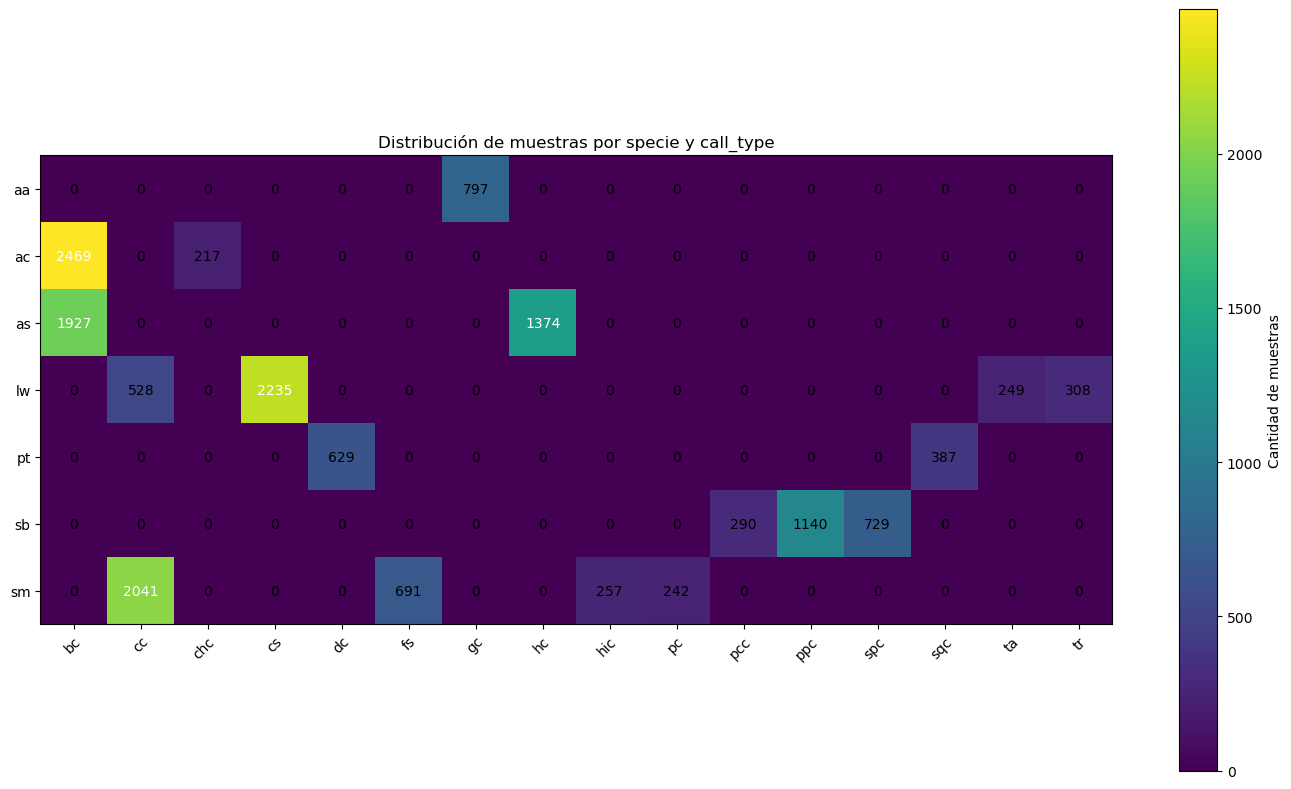

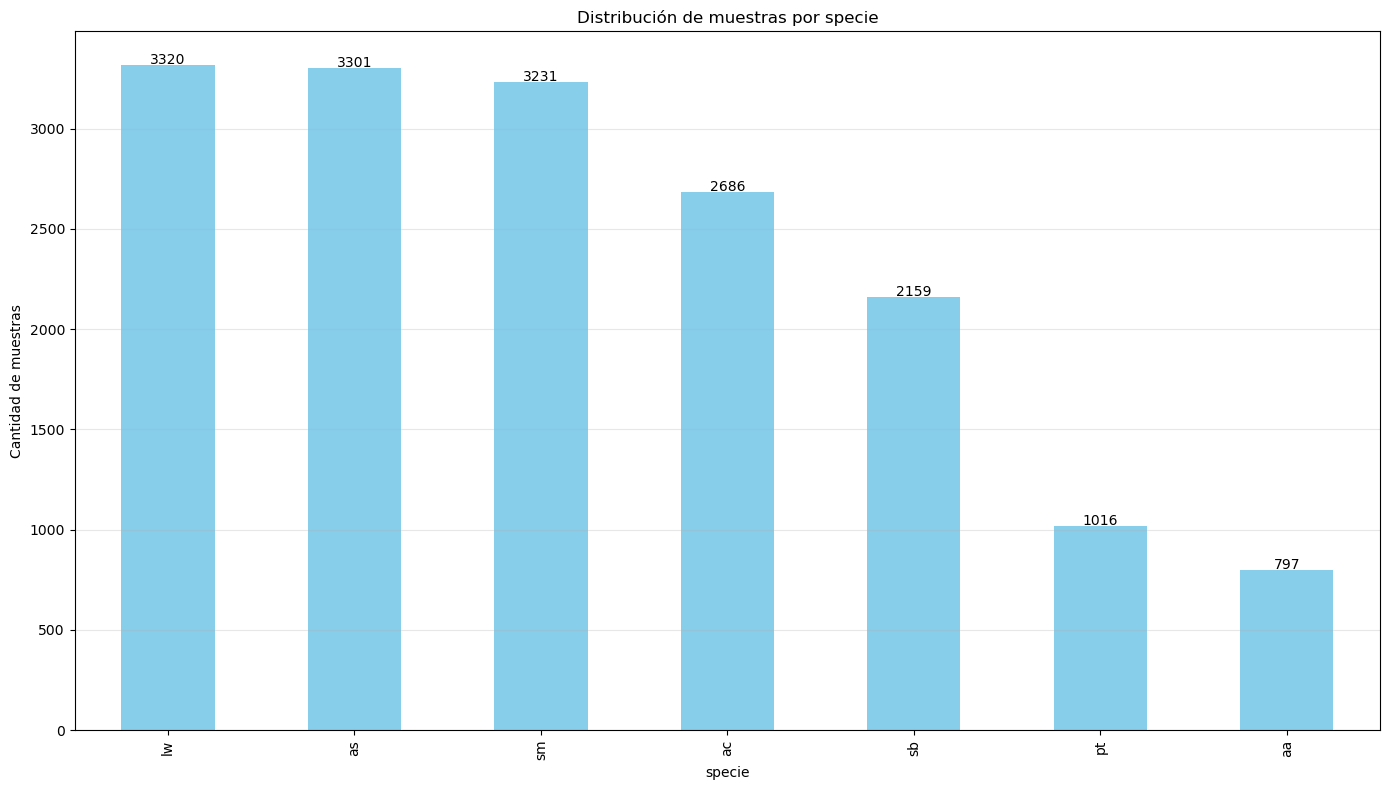

In [8]:
# Visualizar distribución de muestras por grupo
plot_distribution_by_group(processed_annotations, group_cols=["specie", "call_type"])

# También podemos visualizar la distribución solo por especie
plot_distribution_by_group(processed_annotations, group_cols=["specie"])

Archivo seleccionado: /home/nhrot/Programming/Python/banana-net/notebooks/../data/raw/weddells_saddleBack_tamarin__LW/20240520_071536.wav
Número de anotaciones para este archivo: 7


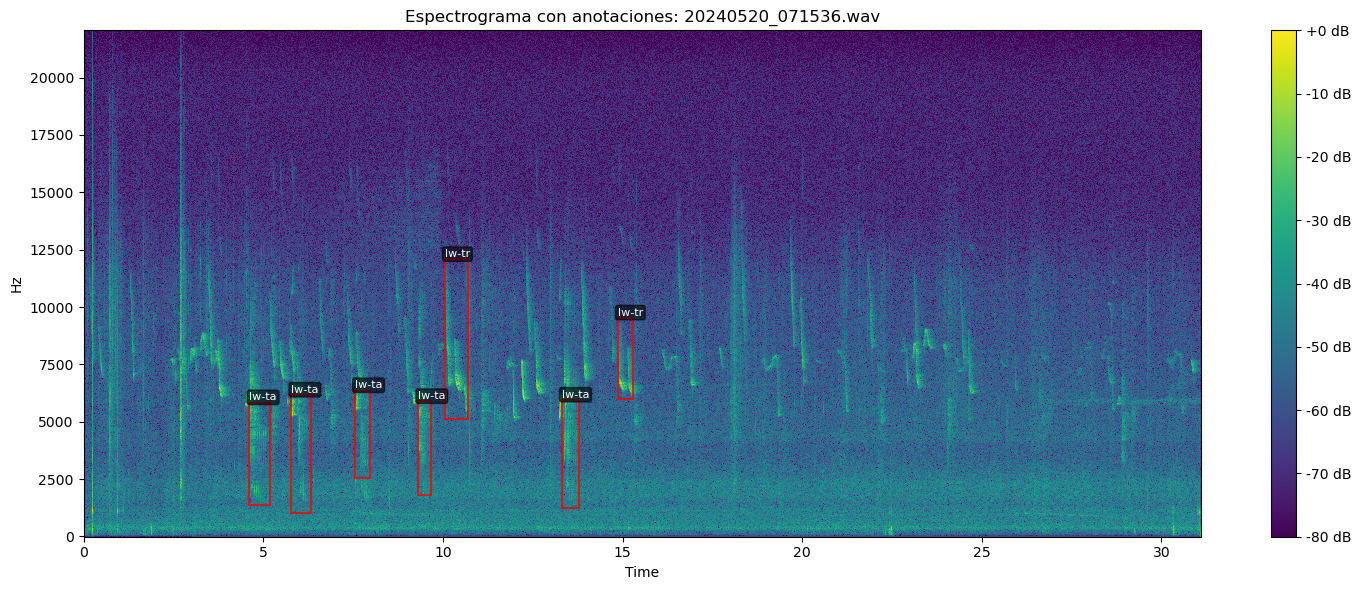

In [9]:
# Paso 7: Visualizar espectrogramas con anotaciones
# Seleccionamos un archivo de audio aleatorio para visualizar
audio_files = processed_annotations["recording_file"].unique()
random_audio = np.random.choice(audio_files)
random_specie_dir = processed_annotations[
    processed_annotations["recording_file"] == random_audio
]["directory"].iloc[0]

# Construimos la ruta completa al archivo
audio_path = os.path.join(RAW_DATA_SUBDIR, random_specie_dir, random_audio)
print(f"Archivo seleccionado: {audio_path}")

# Filtramos las anotaciones para este archivo
file_annotations = processed_annotations[
    processed_annotations["recording_file"] == random_audio
]
print(f"Número de anotaciones para este archivo: {len(file_annotations)}")

# Visualizamos el espectrograma con las anotaciones
plot_spectrogram_with_boxes(audio_path, file_annotations)

# Para escuchar el audio
audio_data, sr = librosa.load(audio_path, sr=None)
display(Audio(audio_data, rate=sr))

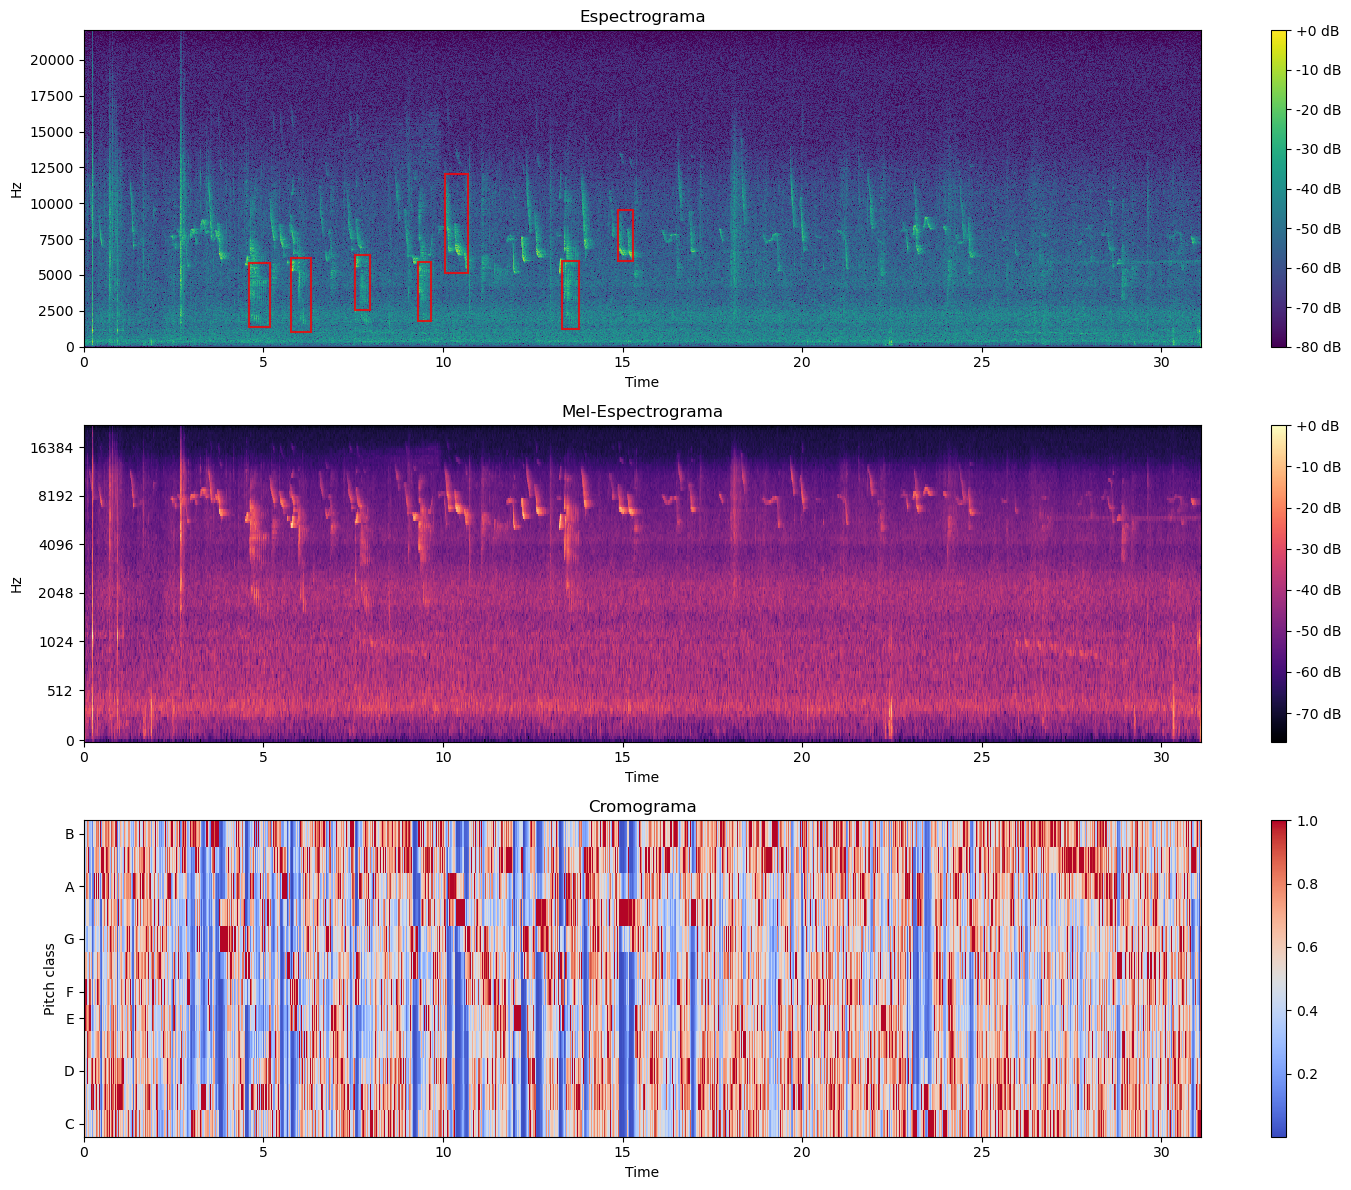

In [10]:
# Paso 8: Visualizar características espectrales detalladas
# Usamos el mismo archivo de audio seleccionado anteriormente
plot_spectral_features(
    audio_path,
    processed_annotations[processed_annotations["recording_file"] == random_audio],
)

2025-06-15 12:15:29,440 — banana_net — INFO — Visualizando resultados de anchor boxes...


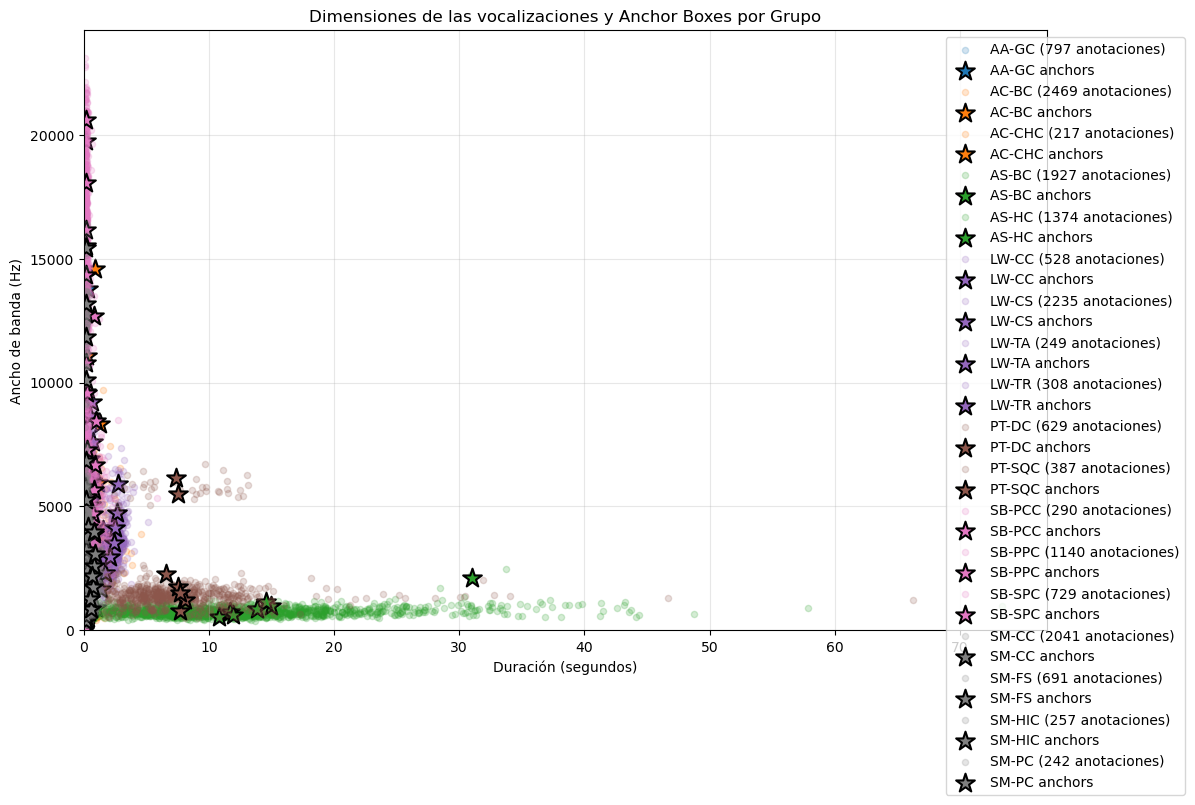

In [11]:
# Paso 9: Calcular y visualizar anchor boxes
# Función para calcular anchor boxes usando k-means en las dimensiones
def calculate_anchor_boxes(dimensions_dict, k=5):
    """
    Calcula anchor boxes para cada grupo usando k-means clustering.

    Args:
        dimensions_dict: Diccionario con dimensiones por grupo
        k: Número de clusters (anchor boxes) por grupo

    Returns:
        Diccionario con las anchor boxes por grupo
    """
    from sklearn.cluster import KMeans

    anchors_dict = {}

    for group, dimensions in dimensions_dict.items():
        if len(dimensions) < k:
            # Si hay menos muestras que clusters, usamos todas las muestras como anchors
            anchors_dict[group] = dimensions
            print(
                f"Grupo {group} tiene menos de {k} muestras. Usando todas como anchors."
            )
        else:
            # Aplicar k-means
            kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
            kmeans.fit(dimensions)
            anchors = kmeans.cluster_centers_
            anchors_dict[group] = anchors

    return anchors_dict


grouped_dimensions = extract_dimensions_by_group(processed_annotations)

# Calcular anchor boxes para cada grupo
anchor_boxes = calculate_anchor_boxes(grouped_dimensions, k=7)

# Visualizar las anchor boxes junto con las dimensiones de las anotaciones
visualize_anchor_results(anchor_boxes, grouped_dimensions)

# Paso 10: Exportar el dataset procesado a un archivo CSV
# Crear el directorio si no existe
os.makedirs(PROCESSED_DATA_SUBDIR, exist_ok=True)

In [13]:
# Calculamos un conjunto global de anchor boxes usando todas las dimensiones
all_dimensions = np.vstack([dims for dims in grouped_dimensions.values()])

# Aplicamos K-means para obtener anchor boxes globales
from sklearn.cluster import KMeans

k = 10  # Número de anchor boxes globales
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
kmeans.fit(all_dimensions)
global_anchors = kmeans.cluster_centers_

print("Anchor boxes globales (duración_s, ancho_banda_hz):")
for i, anchor in enumerate(global_anchors):
    print(f"Anchor {i+1}: ({anchor[0]:.4f} s, {anchor[1]:.0f} Hz)")

Anchor boxes globales (duración_s, ancho_banda_hz):
Anchor 1: (0.4614 s, 2441 Hz)
Anchor 2: (0.2005 s, 13123 Hz)
Anchor 3: (0.5310 s, 4498 Hz)
Anchor 4: (4.0453 s, 656 Hz)
Anchor 5: (0.1884 s, 20047 Hz)
Anchor 6: (0.3826 s, 8917 Hz)
Anchor 7: (0.4694 s, 3396 Hz)
Anchor 8: (0.8486 s, 6117 Hz)
Anchor 9: (0.1801 s, 16606 Hz)
Anchor 10: (1.6220 s, 1593 Hz)
